# ML Pipeline Preparation

## Import packages and load data from database

In [1]:
# Imports
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import nltk
import re
from time import time, perf_counter
import matplotlib.pyplot as plt
import pickle
from joblib import dump, load

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import classification_report, roc_auc_score, make_scorer
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

In [2]:
# Download packages from NLTK
nltk.download(['punkt', 'wordnet', 'stopwords'])

[nltk_data] Downloading package punkt to /Users/tjdauer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tjdauer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tjdauer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Import a tokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [4]:
# Load data from the database, data.db
engine = create_engine('sqlite:///../data/data.db')
df = pd.read_sql("SELECT * FROM LabeledMessages", engine)

In [5]:
# Take a look at the data
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Define the series of messages X and the target matrix Y
X = df['message']
Y = df.drop(columns=['id', 'message', 'original', 'genre'])

In [7]:
# Display the first few entries of X
X.head()

0    Weather update - a cold front from Cuba that c...
1              Is the Hurricane over or is it not over
2                      Looking for someone but no name
3    UN reports Leogane 80-90 destroyed. Only Hospi...
4    says: west side of Haiti, rest of the country ...
Name: message, dtype: object

In [8]:
# Display the first few rows of Y
Y.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Function for tokenization and lemmatization

In [9]:
def tokenize(text):
    """Takes some text as input, then tokenizes it, lemmatizes it, strips it
        of characters that are not letters or numbers, and normalizes its case 
        (to lowercase only).
        
    Arguments:
    text -- a string of text.
    
    Returns:
    tokens_cleaned -- the final list of cleaned tokens.
    """
    text = text.lower()
    text = re.sub('[^a-z0-9]', ' ', text)
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens_cleaned = [lemmatizer.lemmatize(t).strip() for t in tokens]
    return tokens_cleaned

In [10]:
# Use the function on an example sentence
print(tokenize('I thanked Ms. Smith. She is a great teacher.'))

['i', 'thanked', 'm', 'smith', 'she', 'is', 'a', 'great', 'teacher']


In [13]:
# Create stopwords that are consistent with my tokenizer
my_stopwords = set([tokenize(w)[0] for w in stopwords.words('english')])
# I used `set` to delete duplicates

In [14]:
# Print the stopwords
print(my_stopwords)

{'from', 'wa', 'isn', 'again', 'through', 'then', 'all', 'shouldn', 'there', 'doing', 'while', 'wasn', 'those', 'weren', 'against', 'his', 'very', 'her', 'but', 'their', 'have', 'ha', 'further', 'hasn', 'wouldn', 'yours', 'of', 'ours', 'once', 'y', 'me', 'is', 't', 'now', 'other', 'ma', 'some', 'between', 'at', 'had', 'having', 'until', 'same', 'she', 'him', 'out', 'doe', 'mustn', 'we', 'shan', 'about', 'too', 'not', 'didn', 'haven', 'hers', 'if', 'them', 'be', 've', 'do', 'your', 'for', 'an', 'because', 'only', 'he', 'my', 'i', 'theirs', 'such', 'yourself', 'above', 'being', 'a', 'each', 'in', 's', 'ain', 'just', 'under', 'by', 'will', 'hadn', 're', 'below', 'down', 'nor', 'should', 'both', 'they', 'which', 'don', 'needn', 'with', 'or', 'this', 'before', 'that', 'when', 'why', 'into', 'no', 'after', 'll', 'whom', 'these', 'herself', 'itself', 'you', 'here', 'm', 'up', 'to', 'the', 'where', 'been', 'during', 'most', 'any', 'on', 'over', 'our', 'himself', 'than', 'can', 'themselves', 'a

## Machine learning pipeline

I'd like to create a machine learning pipeline to predict category values given new messages. But first, there's an issue with the data that I need to deal with. Some of the messages become the empty string after applying the tokenizer and removing stopwords; these will cause an error when using `CountVectorizer`. I will therefore check for such messages explicitly and remove the corresponding rows. I'll do this by making each message into a set of tokenized words, subtracting the set of stopwords (subtracting as sets is faster than using a list-based approach), and then seeing if the result is the empty set. Alternatively, I could use `try`-`except` to see on which rows the `CountVectorizer` with my tokenizer and stop words fails, but that approach is rather wasteful since I don't need to do vectorization on rows that don't return the empty set after tokenization and stopword removal.

In [16]:
# Compute the result after tokenization and stopword removal on the messages
X_check = X.apply(lambda x: set(tokenize(x)) - my_stopwords)

In [17]:
# Find the resulting rows
failed_rows = X_check[X_check == set()].index
X_check[failed_rows]

12031    {}
Name: message, dtype: object

In [18]:
# Drop the appropriate row(s)
X.drop(failed_rows, inplace=True)
Y.drop(failed_rows, inplace=True)

Now I'll create two pipelines. They both apply a `CountVectorizer` first and then a TF.IDF transformer. For one of them, I then feed this into a different Random Forest Classifier for each column of $Y$ using `MultiOutputClassifier`. For the other, I use `RandomForestClassifier`'s built-in ability to handle multiple outputs, training a single model to simultaneously predict all the outputs (columns of $Y$). For the former, 35 models are independently trained (one for each column of $Y$), but for the latter only one model is trained. As explained [here](https://scikit-learn.org/stable/modules/tree.html#tree-multioutput), advantages of the second approach are shorter training time and typically improved generalization accuracy.

Below, I create, train, and make predictions using both pipelines.

In [22]:
# Create a Pipeline that uses a CountVectorizer with my above tokenizer
# function, then uses a Tf-idf transformer, then uses an independent
# random forest classifier for each output 
# (utilizing MultiOutputClassifier())
pipe_multi = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize, stop_words=my_stopwords)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=42))),
    ])

In [19]:
# Use the same first two steps as in the previous cell, but now use a 
# single random forest classifier in the last step
pipe_single = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize, stop_words=my_stopwords)),
        ('tfidf', TfidfTransformer()),
        ('clf', RandomForestClassifier(random_state=42)),
    ])

## Training

Now I'll split the data into train and test sets, then fit the model to the train set.

In [20]:
# Do a train-test split, with 30% of the data treated as test data
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)

In [25]:
# Fit the first pipeline to the train data
t0 = time()
pipe_multi.fit(X_train, Y_train)
t1 = time()
print(f'Fitting time = {t1 - t0:.3g} seconds')

Fitting time = 160 seconds


In [21]:
# Fit the second pipeline to the train data
t0 = time()
pipe_single.fit(X_train, Y_train)
t1 = time()
print(f'Fitting time = {t1 - t0:.3g} seconds')

Fitting time = 40.9 seconds


The first pipeline takes about 4 times as long to train.

## Testing

Now I'll use the fitted models to make predictions on the test data.

In [27]:
# Use the first fitted pipeline
t0 = time()
Y_pred_multi = pipe_multi.predict(X_test)
t1 = time()
print(f'Prediction time = {t1 - t0:.3g} seconds')

Prediction time = 39.8 seconds


In [22]:
# Use the second fitted pipeline
t0 = time()
Y_pred_single = pipe_single.predict(X_test)
t1 = time()
print(f'Prediction time = {t1 - t0:.3g} seconds')

Prediction time = 3.14 seconds


The first pipeline takes more than 10 times as long to make predictions than the second does.

In [29]:
# Use the `score` method to find the score of the first fitted pipeline
pipe_multi.score(X_test, Y_test)

0.27148162376744783

I'm not sure how this score is calculated. According to Scikit-Learn's documentation, the default scorer for the pipeline is the same as that for the last esimator, in this case a random forest classifier. But `RandomForestClassifier()`'s scoring metric is the mean accuracy, and as we'll see below, the accuracy reported by `classification_report` is significantly higher than 0.27 for every column of $Y$.

Now I'll print a classification report for each pipeline, reporting various metrics measured on the test set predictions versus true values. I'll print the report so that for each target variable, the first pipeline's report and then the second's are printed consecutively; that way they can be more easily compared at a glance.

In [26]:
list(Y.columns).index('child_alone')

9

In [32]:
report = classification_report(Y_test['child_alone'], Y_pred_single[:, 9], zero_division=0,
                              output_dict=True)

In [40]:
'0' in report.keys()

True

In [35]:
try:
    report['1']
except KeyError:
    print('Key error')

Key error


In [30]:
# Print classification reports
for i, col in enumerate(Y_test.columns):
    print(f'\033[1m{col}:\033[0m Pipeline 1')
    print(classification_report(Y_test[col], Y_pred_multi[:, i], zero_division=0))
    print(f'\033[1m{col}:\033[0m Pipeline 2')
    print(classification_report(Y_test[col], Y_pred_single[:, i], zero_division=0))
    print('-'*60)

related: Pipeline 1
              precision    recall  f1-score   support

           0       0.72      0.39      0.51      1844
           1       0.84      0.95      0.89      5965

    accuracy                           0.82      7809
   macro avg       0.78      0.67      0.70      7809
weighted avg       0.81      0.82      0.80      7809

related: Pipeline 2
              precision    recall  f1-score   support

           0       0.69      0.54      0.60      1844
           1       0.87      0.92      0.89      5965

    accuracy                           0.83      7809
   macro avg       0.78      0.73      0.75      7809
weighted avg       0.82      0.83      0.83      7809

------------------------------------------------------------
request: Pipeline 1
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      6474
           1       0.81      0.50      0.62      1335

    accuracy                           0.89      7809
   macr

Note that I set `zero_division=0`; this means when there are no predicted instances in a class, the precision is set to zero (there is a division by zero in its calculation, since there are no positive predictions). The precision is not meaningful in this case, so I may as well just set it to zero instead of using the default `zero_division='warn'`, which also sets it to zero but has the annoying effect of printing a bunch of warnings.

The numbers look fairly similar, though the first pipeline consistently does a bit better. I'll check this a bit more explicitly as follows. What I'm really concerned with are the F1 score (harmonic mean of precision and recall) and the recall of the predictors on the '1' class, that is, the class of messages that are known to be in the categories after which they are named (for example, a message in the '1' class in 'medical_help' indicates that medical help is needed). 

In fact, I care signficantly more about recall than precision for this class: For each column with the exception of 'related', the vast majority of messages are in the '0' class, meaning not in that category. The goal is to pick out (recall) from this vast sea of messages almost all the messages in class '1' and forward those to human disaster response professionals, who can then quickly determine whether the message is relevant. Of course, I could have a recall of 1 in this class by just having the predictor predict class '1' on every message, but that would be pointless - the professionals would then have a ton of work to do to sift through all those messages. It depends on the size of the class imbalance, but typically a precision of 50% is fine - even though half the predicted '1's are false positives in this case, that's still a less work for the humans.

What does this mean? F1 score is certainly better to look at than raw accuracy (not a good metric at all due to class imbalance), but it's not ideal for most targets since the class imbalance is generally quite large. So here I'll look at the F1 score and recall explicitly between the two predictors; later I will probably create custom metrics that treat the precision/recall tradeoff in a more sensible way for each target.

In [31]:
# Show the F1 score and recall for each pipeline, for each target
for i, col in enumerate(Y_test.columns):
    print(f'\033[1m{col}:\033[0m Pipeline 1 vs 2')
    report_1 = classification_report(
        Y_test[col], Y_pred_multi[:, i], zero_division=0, output_dict=True)
    report_2 = classification_report(
        Y_test[col], Y_pred_single[:, i], zero_division=0, output_dict=True)
    f1_score_1 = report_1['1']['f1-score']
    f1_score_2 = report_2['1']['f1-score']
    recall_1 = report_1['1']['recall']
    recall_2 = report_2['1']['recall']
    print(f'F1 score: {f1_score_1:.3g} vs {f1_score_2:.3g}')
    print(f'recall: {recall_1:.3g} vs {recall_2:.3g}')
    print('-'*60)

related: Pipeline 1 vs 2
F1 score: 0.891 vs 0.895
recall: 0.953 vs 0.925
------------------------------------------------------------
request: Pipeline 1 vs 2
F1 score: 0.62 vs 0.62
recall: 0.503 vs 0.506
------------------------------------------------------------
offer: Pipeline 1 vs 2
F1 score: 0 vs 0
recall: 0 vs 0
------------------------------------------------------------
aid_related: Pipeline 1 vs 2
F1 score: 0.739 vs 0.656
recall: 0.713 vs 0.553
------------------------------------------------------------
medical_help: Pipeline 1 vs 2
F1 score: 0.122 vs 0.0345
recall: 0.0663 vs 0.0178
------------------------------------------------------------
medical_products: Pipeline 1 vs 2
F1 score: 0.13 vs 0.0585
recall: 0.0709 vs 0.0304
------------------------------------------------------------
search_and_rescue: Pipeline 1 vs 2
F1 score: 0.0776 vs 0.0439
recall: 0.0407 vs 0.0226
------------------------------------------------------------
security: Pipeline 1 vs 2
F1 score: 0.0126 vs

In general, the first pipeline performs a bit better than the second, which is not surprising since the first fits independent predictors for each target. However, training using the first pipeline is quite slow, and on my laptop it is rather impractical for hyperparameter optimization. Therefore I'll go with pipeline 2 for now, and may later come back to pipeline 1 once I have a better idea of the right hyperparameters to use.

## Improving the model using grid search

Now I want to find better hyperparameters using cross-validation and grid search. Sklearn's `GridSearchCV()` method is convenient for this.

First, I take a look at the model's hyperparameter names:

In [32]:
# Get the hyperparameter names
pipe_single.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(stop_words=['of', 'a', 'aren', 'during', 'isn', 'above', 'more',
                               'to', 'too', 'both', 'mightn', 'him', 'hers', 'our',
                               'doesn', 'at', 'we', 'before', 'your', 'doing',
                               'ourselves', 'ain', 's', 'do', 'ours', 'up',
                               'against', 'such', 'i', 'my', ...],
                   tokenizer=<function tokenize at 0x12eb58940>)),
  ('tfidf', TfidfTransformer()),
  ('clf', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'vect': CountVectorizer(stop_words=['of', 'a', 'aren', 'during', 'isn', 'above', 'more',
                             'to', 'too', 'both', 'mightn', 'him', 'hers', 'our',
                             'doesn', 'at', 'we', 'before', 'your', 'doing',
                             'ourselves', 'ain', 's', 'do', 'ours', 'up',
                             'against', 'such', 'i', 'my', ...],
             

Now I'll write some functions to do grid search in a convenient way and print metrics for evaluating predictions.

In [33]:
def print_metrics(Y_true, Y_pred):
    '''Takes predicted and true labels and prints
        the accuracy, precision, recall, and F1 score.
    Args:
        Y_true -- an array or dataframe of the true class labels.
        Y_pred -- an array or dataframe of the predicted class labels.
    Returns:
        None; instead, prints the accuracy, precision, recall, and 
        F1 score.
    '''
    eq_arr = np.array(Y_pred == Y_true)
    pos_arr = np.array(Y_true == 1)
    neg_arr = np.array(Y_true == 0)
    P = np.sum(pos_arr)
    TP = np.sum(pos_arr*eq_arr)
    FN = P - TP
    N = np.sum(neg_arr)
    TN = np.sum(neg_arr*eq_arr)
    FP = N - TN
    accuracy = (TP + TN)/(P + N)
    precision = TP/(TP + FP)
    recall = TP/P
    f1 = 2/(1/precision + 1/recall)
    print(f'accuracy = {accuracy:.3g}')
    print(f'precision = {precision:.3g}')
    print(f'recall = {recall:.3g}')
    print(f'F1 score = {f1:.3g}')

In [203]:
def do_grid_search(pipe, parameters, X_train, Y_train, scorer=None, n_jobs=1, cv=None):
    '''Does a grid search to optimize hyperparameters.
    Args:
        pipe -- a Pipe() object representing a machine learning pipeline.
        parameters -- a dict of parameters to be used by GridSearchCV().
        Y_true -- a dataframe or array of the true class labels.
        scorer -- an optional scoring function.
        n_jobs -- the number of jobs to run in parallel. The default is 1, 
                    though I will typically use 7 since my Macbook Air has
                    8 CPU cores.
        cv -- something to be used for cross validation, such as an instance
                of StratifiedShuffleSplit().
    Returns:
        result_cv -- the object output by GridSearchCV() after fitting, with
                all its parameters and methods accessible.
        Also displays the dataframe of CV results and prints the
        total runtime for training and testing.
    '''
    # Create the GridSearchCV object with default 5-fold cross-validation
    result_cv = GridSearchCV(pipe_single, parameters, refit=True, scoring=scorer,
                             n_jobs=n_jobs, cv=cv)
    # Do fits and find the runtime
    t0 = perf_counter()
    result_cv.fit(X_train, Y_train)
    # Display the results
    display(pd.DataFrame(result_cv.cv_results_))
    t1 = perf_counter()
    print(f'Runtime = {t1 - t0: .3g} seconds')
    return result_cv

To see if this is working properly, I first try it with just one parameter value (which is the same as in the fit in the previous section).

In [204]:
parameters = {'vect__max_features': [None]
              }

do_grid_search(pipe_single, parameters, X_train, Y_train, n_jobs=7)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vect__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,39.785512,0.018044,2.472597,0.015862,None,{'vect__max_features': None},0.288968,0.301043,0.29034,0.295635,0.291243,0.293446,0.004406,1


Runtime =  85.6 seconds


GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(stop_words=['of', 'a',
                                                                    'aren',
                                                                    'during',
                                                                    'isn',
                                                                    'above',
                                                                    'more',
                                                                    'to', 'too',
                                                                    'both',
                                                                    'mightn',
                                                                    'him',
                                                                    'hers',
                                                                    'our',
                              

As mentioned above, I'm not sure how the test scores are calculated. I will create a custom scoring function instead of relying on the default behavior.

In [91]:
def score_func(Y_true, Y_pred, c=1, weights='equal'):
    '''Takes the true and predicted class labels and returns
        a score that is similar to the F1 score, but weighted
        to favor the recall by a factor of c.
        Using the default c=1 causes the F1 score to be returned.
        Using c='recall' causes the recall to be returned.
    Args:
        Y_true -- an array or dataframe of true class labels.
        Y_pred -- an array or dataframe of predicted class labels.
        c -- a nonzero number that weights the recall in the score 
             for a column,
             or the string 'recall', meaning the recall is the score
             for each column.
        weights -- a numeric list of length Y_true.shape[1] that gives 
                   the weight assigned to each target (column) in the
                   final score. It can also be the string 'equal', 
                   which gives equal weights of size 1/Y_true.shape[1].
    Returns:
        score -- a score for the predictions over all targets, 
                 weighted for each target by some choice of weights.
    '''
    score_list = []
    Y_true = np.array(Y_true)
    Y_pred = np.array(Y_pred)
    if Y_true.ndim == 1:
        Y_true = np.reshape(Y_true, (-1, 1))
    if Y_pred.ndim == 1:
        Y_pred = np.reshape(Y_pred, (-1, 1))
    for col_number in range(Y_true.shape[1]):
        pred = Y_pred[:, col_number]
        true = Y_true[:, col_number]
        eq_arr = np.array(pred == true)
        pos_arr = np.array(true == 1)
        neg_arr = np.array(true == 0)
        P = np.sum(pos_arr)
        TP = np.sum(pos_arr*eq_arr)
        FN = P - TP
        N = np.sum(neg_arr)
        TN = np.sum(neg_arr*eq_arr)
        FP = N - TN
        accuracy = (TP + TN)/(P + N)
        # Note I need to deal with the case where the calculation of 
        # precision involves dividing by zero; in this case I will
        # set the precision to be zero.
        precision = 0 if (TP + FP == 0) else TP/(TP + FP)
        recall = TP/P
        if c == 'recall':
            score_list.append(recall)
        else:
            if recall*precision == 0:
                # If either of recall or precision is zero,
                # then I set the score to be zero.
                score_list.append(0)
            else:
                score_list.append(2/(1/precision + 1/(c*recall)))
    score_arr = np.array(score_list)
    if weights == 'equal':
        weights = (1/Y_true.shape[1])*np.ones(Y_true.shape[1])
    score = sum(score_arr*weights)
    return score

In [57]:
Y_pred = pipe_multi.predict(X_test)

In [58]:
score_func(Y_test, Y_pred)

0.2615856066781391

In [61]:
# Make the scorer using sklearn's `make_scorer` function
# Here c = 1, so this is the F1 score
my_scorer = make_scorer(score_func)

In [40]:
cv = do_grid_search(pipe_single, parameters, X_train, Y_train, scorer=my_scorer, n_jobs=7)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vect__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,40.427753,0.537777,1.971462,0.195831,None,{'vect__max_features': None},0.204039,0.210502,0.198295,0.203314,0.196648,0.20256,0.004878,1


Runtime =  84.7 seconds


Now this makes sense to me: I've set things up so that the hyperparameter values in the `parameters` grid that maximize the F1 score (on instances labeled 1) are chosen. Now I will do a real hyperparameter search.

I may want to limit the number of features produced by the vectorizer (i.e. cut off some of the least common words). First, I'll check how many features it produces:

In [41]:
# Find the number of features produced by the vectorizer
len(pipe_single['vect'].get_feature_names_out())

25615

I'll try some smaller values (which will result in shorter fitting times) and see if that produces better results.

I'll also try both $L^1$ and $L^2$ norms for the TF.IDF transformer, as well as several values for the number of estimators, minimum samples split, and class weight strategy for the random forest model.

The runtimes here are still fairly long, at least for a personal project on my laptop, so I'll do things somewhat iteratively instead of just running a full grid search. This may not be as good as a full grid search, since the parameters are not necessarily independent of each other. For example, I could search just over the number of features from the count vectorizer and find that value $n$ is the best (with the other hyperparameter values fixed). Then I could search over the number of estimators and find some optimal value $m$ there. But there's no guarantee that using the values $n$ and $m$ for these respective parameters will be the best combination in the two-dimensional space of those parameters. However, I've found in my personal projects that an iterative approach often works reasonably well, and often the perfect is the enemy of the good since the runtimes are so long for a full grid search. Ultimately, I am looking to make my model better, and will be satisfied to some extent by improvement even if there is a better set of hyperpameters out there somewhere that would take much longer to find.

Now, to get started. First, I want to get an idea of how many features from the count vectorizer to keep.

In [42]:
# Make a dictionary with the parameter values to try
parameters = {'vect__max_features': [None, 10000, 5000, 2500, 1000], 
              }

# Do the grid search
cv = do_grid_search(pipe_single, parameters, X_train, Y_train,
                    scorer=my_scorer, n_jobs=7);

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vect__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,50.300950,0.540791,2.660276,0.127377,None,{'vect__max_features': None},0.204039,0.210502,0.198295,0.203314,0.196648,0.202560,0.004878,5
1,42.558283,0.822314,2.399382,0.105517,10000,{'vect__max_features': 10000},0.215233,0.217657,0.211693,0.216754,0.207432,0.213754,0.003759,4
2,40.065170,0.181855,2.423074,0.086247,5000,{'vect__max_features': 5000},0.233381,0.229144,0.222975,0.227927,0.221848,0.227055,0.004217,3
3,38.143414,0.121270,2.233253,0.065808,2500,{'vect__max_features': 2500},0.237244,0.243949,0.228733,0.238439,0.235735,0.236820,0.004903,2
4,27.172210,3.182714,1.546184,0.265730,1000,{'vect__max_features': 1000},0.249451,0.257467,0.245812,0.248323,0.248546,0.249920,0.003962,1


Runtime =  188 seconds


Interesting! Using just 1000 of these features works best, though the improvement in the F1 score is not huge. Unfortunately, it appears I didn't choose the lowest value to be small enough to find the maximum mean test score, so I'll try some more values.

In [43]:
# Make a dictionary with the parameter values to try
parameters = {'vect__max_features': [900, 700, 500, 300], 
              }

# Do the grid search
cv = do_grid_search(pipe_single, parameters, X_train, Y_train,
                    scorer=my_scorer, n_jobs=7);

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vect__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,33.115089,0.025233,2.922883,0.011660,900,{'vect__max_features': 900},0.250949,0.256239,0.247496,0.250167,0.246433,0.250257,0.003421,3
1,31.880285,0.641064,2.451122,0.315770,700,{'vect__max_features': 700},0.258448,0.260738,0.247388,0.249220,0.246348,0.252428,0.005966,2
2,30.109074,0.806639,2.590239,0.317651,500,{'vect__max_features': 500},0.259372,0.267971,0.255008,0.253090,0.249962,0.257081,0.006241,1
3,25.355609,0.035785,2.395975,0.009693,300,{'vect__max_features': 300},0.244194,0.252744,0.249532,0.251776,0.242762,0.248202,0.004021,4


Runtime =  122 seconds


Looking at the standard errors (which are the standard deviations `std_test_score` divided by $\sqrt{5})$, the mean test scores using 900, 700, and 500 features are statistically indistinguishable from each other, but using 300 features is clearly worse. I'll use 500 features to keep the runtimes down. Next, I'll try comparing using balanced class weights versus the default of equal class weights of 1, and I'll also see whether using the $L^1$ or $L^2$ norm for the TF.IDF transformer works better.

In [44]:
# Make a dictionary with the parameter values to try
parameters = {'vect__max_features': [500],
              'tfidf__norm': ['l1', 'l2'], 
              'clf__class_weight': [None, 'balanced']
              }
# Do the grid search
cv = do_grid_search(pipe_single, parameters, X_train, Y_train, 
                    scorer=my_scorer, n_jobs=7);

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__class_weight,param_tfidf__norm,param_vect__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,30.077774,0.013312,3.198230,0.010278,None,l1,500,"{'clf__class_weight': None, 'tfidf__norm': 'l1...",0.256261,0.259777,0.247116,0.249480,0.250273,0.252581,0.004693,2
1,30.439278,0.324433,3.166538,0.027567,None,l2,500,"{'clf__class_weight': None, 'tfidf__norm': 'l2...",0.259372,0.267971,0.255008,0.253090,0.249962,0.257081,0.006241,1
2,29.341249,1.228560,3.150687,0.674604,balanced,l1,500,"{'clf__class_weight': 'balanced', 'tfidf__norm...",0.172416,0.179246,0.166122,0.168381,0.170931,0.171419,0.004467,4
3,27.643835,0.371092,3.030084,0.208228,balanced,l2,500,"{'clf__class_weight': 'balanced', 'tfidf__norm...",0.177995,0.184175,0.179835,0.177951,0.175977,0.179187,0.002777,3


Runtime =  122 seconds


Using balanced class weights clearly does worse than not using them. There isn't much difference in performance between $L^1$ and $L^2$ metrics being used, with $L^2$ being just slightly better.

It's interesting that using balanced class weights in `RandomForestClassifier` doesn't yield better results; for most of the target columns, the classes are quite imbalanced, so I would expect using balanced class weights to help. I suspect that I need to train different random forests for each of the target columns to take advantage of the balanced weights approach, as the imbalance varies a lot between the targets.

Finally, I'll try a few values for the minimum number of samples required to split an internal node (`min_samples_split`) and the number of trees in the forest (`n_estimators`).

In [45]:
# Make a dictionary with the parameter values to try
parameters = {'vect__max_features': [500],
              'clf__min_samples_split': [2, 3, 4],
              'clf__n_estimators': [50, 100, 200]
              }

# Do the grid search
cv = do_grid_search(pipe_single, parameters, X_train, Y_train,
                    scorer=my_scorer, n_jobs=7);

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__min_samples_split,param_clf__n_estimators,param_vect__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,16.736962,0.038441,1.431813,0.056901,2,50,500,"{'clf__min_samples_split': 2, 'clf__n_estimato...",0.255531,0.261703,0.256105,0.251323,0.252570,0.255446,0.003602,7
1,31.038532,0.744772,2.418251,0.203768,2,100,500,"{'clf__min_samples_split': 2, 'clf__n_estimato...",0.259372,0.267971,0.255008,0.253090,0.249962,0.257081,0.006241,5
2,60.077842,0.449682,4.579705,0.292684,2,200,500,"{'clf__min_samples_split': 2, 'clf__n_estimato...",0.262370,0.268882,0.254261,0.256976,0.254217,0.259341,0.005619,1
3,16.736596,0.178985,1.474098,0.033142,3,50,500,"{'clf__min_samples_split': 3, 'clf__n_estimato...",0.260934,0.267176,0.255395,0.252899,0.256447,0.258570,0.005028,2
4,30.215677,0.265763,2.209244,0.291816,3,100,500,"{'clf__min_samples_split': 3, 'clf__n_estimato...",0.257970,0.266255,0.255736,0.251952,0.252136,0.256810,0.005238,6
5,57.021841,0.103245,4.125410,0.390502,3,200,500,"{'clf__min_samples_split': 3, 'clf__n_estimato...",0.260316,0.267578,0.254942,0.254343,0.252486,0.257933,0.005481,3
6,16.633111,0.110714,1.470584,0.113113,4,50,500,"{'clf__min_samples_split': 4, 'clf__n_estimato...",0.258780,0.266520,0.257201,0.253050,0.251246,0.257359,0.005327,4
7,29.267295,0.157156,2.030930,0.097063,4,100,500,"{'clf__min_samples_split': 4, 'clf__n_estimato...",0.254766,0.264434,0.256616,0.251844,0.248266,0.255185,0.005419,8
8,47.068951,3.348214,2.786811,0.595060,4,200,500,"{'clf__min_samples_split': 4, 'clf__n_estimato...",0.257434,0.263399,0.252524,0.251068,0.247593,0.254404,0.005498,9


Runtime =  296 seconds


Using more estimators improves the scores, though only slightly. Using `min_samples_split` = 3 does better than the default value of 2, so I will use that.

## Testing the tuned model

In [46]:
# Show the best hyperparameter values that were found
cv.best_params_

{'clf__min_samples_split': 2,
 'clf__n_estimators': 200,
 'vect__max_features': 500}

In [47]:
# Make predictions on the test set and show the appropriate metrics
Y_pred = cv.best_estimator_.predict(X_test)
print_metrics(Y_test, Y_pred)

accuracy = 0.946
precision = 0.814
recall = 0.521
F1 score = 0.636


What were the values of these metrics for the original model?

In [48]:
# Make predictions and show metrics for the original model
Y_pred = pipe_single.predict(X_test)
print_metrics(Y_test, Y_pred)

accuracy = 0.943
precision = 0.846
recall = 0.46
F1 score = 0.596


The precision is a bit greater for the original model, but I don't care about that too much; the precision/recall tradeoff still favors precision too much for this application. The recall and F1 score are a few percent better for my tuned model.

## Improving the tuned model further

As I mentioned above, while it's more appropriate than the accuracy, the F1 score is still not the right metric for this problem. What I really want is to reduce the work that human disaster response professionals have to do in reading the messages that come in to a maneagable level, while catching almost all the messages that are in a given category. In other words, for each of the categories, I want the recall to be very high, say greater than 90%, while having precision high enough that no more than half the messages the humans have to read are irrelevant.

My original model above did pretty well in terms of recall for the 'related' column. It would make sense to me if no messages that are unrelated (i.e. have a value of 0 in this column) have a value of 1 in any other column (since they are presumably unrelated to the disaster). I'll now check to see if this is really the case.

In [49]:
# Create a dataframe that has targets for unrelated messages only
Y_unrelated = Y_train.drop(Y_train.loc[Y_train['related'] == 1].index)
# Drop the 'related' column
Y_unrelated.drop(columns='related', inplace=True)
# Check whether any of these elements are nonzero
print(sum(Y_unrelated.sum(axis=1)))

0


Good, so my intuition is correct here. This means that it would make some sense to build a very good model to determine whether messages are related at all, then feed only messages that it predicts to be related to another model for each of the other target columns. This would already reduce number of irrelevant messages by about 25%, as that fraction of the messages are not related at all to disasters (I have to say, I would expect this fraction in the real world to be higher).

There are a few next steps I want to take to improve the model:

- Build a separate classifier for the 'related' target that has extremely high recall (> 98%) and use this as an initial step to filter out irrelevant messages for the other target classification tasks.
- Do a stratified split for each column instead of a regular train-test split; I think this is preferable since many of the targets are quite imbalanced.
- Use the recall as my score to optimize during hyperparameter tuning. I'm not sure how much of a difference this will make, as the random forest classifiers themselves do not try to maximize recall (the use the gini criterion for splitting), but I'll give it a try. This idea might be more useful in for training a model where the metric is more customizable, like a neural network. 

I'll start by building a random forest classifier for just the 'response' task. Since the recall is my main concern, I'll use the recall as my scoring function for this optimization.

In [93]:
# Make the scorer using sklearn's `make_scorer` function
my_scorer = make_scorer(score_func, c='recall')

In [94]:
# Do stratified shuffle split
splits = StratifiedShuffleSplit(n_splits=5, random_state=42)

In [95]:
# Make a dictionary with the parameter values to try
parameters = {'vect__max_features': [None, 20000, 15000, 10000, 5000]}

# Do the grid search
cv = do_grid_search(pipe_single, parameters, X_train, Y_train['related'], 
                    scorer=my_scorer, n_jobs=7, cv=splits)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vect__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,15.961211,0.088566,0.676990,0.018190,None,{'vect__max_features': None},0.932568,0.950502,0.942611,0.946915,0.950502,0.944620,0.006690,1
1,14.263965,0.422212,0.674495,0.017101,20000,{'vect__max_features': 20000},0.934720,0.944046,0.950502,0.941894,0.950502,0.944333,0.005909,2
2,12.568137,0.200245,0.664034,0.020906,15000,{'vect__max_features': 15000},0.934003,0.943329,0.942611,0.938307,0.956241,0.942898,0.007463,3
3,11.493215,0.046136,0.656688,0.008081,10000,{'vect__max_features': 10000},0.929699,0.939742,0.932568,0.939024,0.946198,0.937446,0.005800,4
4,8.434960,0.880884,0.541282,0.045797,5000,{'vect__max_features': 5000},0.927547,0.937590,0.931133,0.931851,0.938307,0.933286,0.004083,5


Runtime =  64.1 seconds


The difference between using 20,000 features and the full number is statistically insignificant, so I'll go with using 20,000 since it shortens training time slightly.

In [96]:
# Make a dictionary with the parameter values to try
parameters = {'vect__max_features': [20000],
             'clf__class_weight': [None, 'balanced', 'balanced_subsample']}

# Do the grid search
cv = do_grid_search(pipe_single, parameters, X_train, Y_train['related'], 
                    scorer=my_scorer, n_jobs=7, cv=splits)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__class_weight,param_vect__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.179214,0.027065,0.694166,0.012902,None,20000,"{'clf__class_weight': None, 'vect__max_feature...",0.934720,0.944046,0.950502,0.941894,0.950502,0.944333,0.005909,1
1,14.704716,0.422246,0.668341,0.006235,balanced,20000,"{'clf__class_weight': 'balanced', 'vect__max_f...",0.914634,0.930416,0.931133,0.928981,0.935438,0.928121,0.007078,3
2,14.272680,2.079906,0.611508,0.070297,balanced_subsample,20000,"{'clf__class_weight': 'balanced_subsample', 'v...",0.911047,0.935438,0.932568,0.929699,0.932568,0.928264,0.008798,2


Runtime =  52.3 seconds


Again, using unbalanced class weights works better. I'm a bit surprised by this, although here the class imbalance is not huge (about 3:1), so maybe it's not so puzzling.

I'll finish out the parameter search with a grid for a few more parameters.

In [97]:
# Make a dictionary with the parameter values to try
parameters = {'vect__max_features': [20000], 
              'clf__min_samples_split': [2, 3, 4], 
              'clf__n_estimators': [50, 100, 200],
              'tfidf__norm': ['l1', 'l2'],
              'tfidf__use_idf': [True, False]
             }

# Do the grid search
cv = do_grid_search(pipe_single, parameters, X_train, Y_train['related'], 
                    scorer=my_scorer, n_jobs=7, cv=splits)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__min_samples_split,param_clf__n_estimators,param_tfidf__norm,param_tfidf__use_idf,param_vect__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.845285,0.057213,0.540063,0.007563,2,50,l1,True,20000,"{'clf__min_samples_split': 2, 'clf__n_estimato...",0.936155,0.939024,0.945481,0.942611,0.946198,0.941894,0.003823,35
1,9.339291,0.139648,0.539383,0.009803,2,50,l1,False,20000,"{'clf__min_samples_split': 2, 'clf__n_estimato...",0.944763,0.939024,0.944763,0.947633,0.948350,0.944907,0.003284,32
2,9.134381,0.064673,0.544617,0.012165,2,50,l2,True,20000,"{'clf__min_samples_split': 2, 'clf__n_estimato...",0.928981,0.939742,0.946198,0.941894,0.946915,0.940746,0.006458,36
3,9.550402,0.054693,0.552346,0.008418,2,50,l2,False,20000,"{'clf__min_samples_split': 2, 'clf__n_estimato...",0.936155,0.950502,0.941176,0.945481,0.946198,0.943902,0.004874,34
4,15.279853,0.082567,0.725527,0.008494,2,100,l1,True,20000,"{'clf__min_samples_split': 2, 'clf__n_estimato...",0.940459,0.946198,0.944763,0.946198,0.953372,0.946198,0.004158,29
5,16.041215,0.143308,0.728314,0.009272,2,100,l1,False,20000,"{'clf__min_samples_split': 2, 'clf__n_estimato...",0.946915,0.943329,0.949067,0.949067,0.953372,0.948350,0.003272,17
6,15.421454,0.090901,0.726941,0.007887,2,100,l2,True,20000,"{'clf__min_samples_split': 2, 'clf__n_estimato...",0.934720,0.944046,0.950502,0.941894,0.950502,0.944333,0.005909,33
7,16.137499,0.108512,0.726765,0.008599,2,100,l2,False,20000,"{'clf__min_samples_split': 2, 'clf__n_estimato...",0.940459,0.947633,0.944046,0.949785,0.953372,0.947059,0.004478,24
8,27.767223,0.166172,1.085987,0.016813,2,200,l1,True,20000,"{'clf__min_samples_split': 2, 'clf__n_estimato...",0.942611,0.950502,0.950502,0.949067,0.951937,0.948924,0.003284,13
9,29.214331,0.231285,1.088156,0.005772,2,200,l1,False,20000,"{'clf__min_samples_split': 2, 'clf__n_estimato...",0.949785,0.946198,0.946198,0.952654,0.951937,0.949354,0.002745,9


Runtime =  459 seconds


In [98]:
cv.best_params_

{'clf__min_samples_split': 4,
 'clf__n_estimators': 200,
 'tfidf__norm': 'l1',
 'tfidf__use_idf': False,
 'vect__max_features': 20000}

In [99]:
# Make predictions on the test set and show the appropriate metrics
Y_pred = cv.best_estimator_.predict(X_test)
print_metrics(Y_test['related'], Y_pred)

accuracy = 0.825
precision = 0.836
recall = 0.96
F1 score = 0.894


This is good recall and still fairly good precision. Now I'll see what happens with a highly imbalanced category.

In [100]:
# Find the fraction of rows in the 'offer' class
sum(Y_train['offer'] == 1)/len(Y_train)

0.00411680755296959

Only 0.4% of messages in the training set are in the 'offer' class. My initial pipeline identified no 'offer' messages in the test set - a recall of zero (see the classification report above).

In [101]:
# Make a dictionary with the parameter values to try
parameters = {'vect__max_features': [None]}

# Do the grid search
cv = do_grid_search(pipe_single, parameters, X_train, Y_train['offer'], 
                    scorer=my_scorer, n_jobs=7, cv=splits)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vect__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.403173,0.055678,0.439689,0.013271,None,{'vect__max_features': None},0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Runtime =  8.65 seconds


Still no luck, it seems.

In [102]:
X_train[Y_train[Y_train['offer'] == 1].index].tolist()[:20]

['Looking to donate new ( several-year shelf life , sealed ) non-prescription medications to any organization involved in or impacted by Hurricane Sandy . Red Cross was contacted by a community member whose work department had collected money and purchased these items . Donation approximately fills a 10-ream paper box . Products are NOT used or near expiration .',
 '45 geminies (Inflatable rubber boats) along with out board motors and other diving equipment have been dispatched with the diving team.',
 'It concentrated on two areas: firstly, the rehabilitation of local health, water and sanitation facilities affected by the flooding; and secondly, on increasing the future capacity of the most vulnerable communities nationwide through community-based first aid and disaster preparedness and response programmes, anchored in the development of stronger National Society branches and district and provincial organizational structures.',
 'Out here helping this community .. . The things u see 

It appears that there are some issues with data labeling here, at least in my estimation. To me, the 'offer' category should indicate messages coming in that are direct offers to help, such as, 'We can donate clothing , towels , toys , and food'. A lot of the messages that are labeled as being in this category are news stories, information about aid organizations, or other things. In my estimation, only 6 of the first 20 messages in this category in the training set are direct offers, and only a few more (~10 of 20 total) are relevant at all. This obviously makes it difficult to train an ML model well that will pick many of these up.

Due to the inability to use my custom scorer directly as a metric for training, I'm skeptical that I can do much better with random forests. Perhaps a neural network approach would work better; I will have to look into this further.

But now, I do want to get to a final form for my random forest model. I could optimize the hyperparameters separately for each column, doing 35 grid searches, but that would take a while and would produce a set of models that I'm not sure how to pickle together as one model. Instead, I'll go back to using `MultiOutputClassifier()`, building a random forest classifier for each target but doing just one grid search to find the optimal set of hyperparameters overall. What do I mean by "optimal overall?" I mean the set such that the score I choose is maximized. I will choose to score using only the recall for each column, and weight the first column ('related') at 50% and the rest equally, since the first column is the most important.

I'll use a grid that has 96 combinations of hyperparameters. I expect it to take about an hour to run.

In [243]:
# Make the scorer using sklearn's `make_scorer` function
weights = [0.5]
weights += [(0.5/Y_test.shape[1]) for i in range(Y_test.shape[1])]
my_scorer = make_scorer(score_func, c='recall', weights=weights)

In [104]:
# Make a dictionary with the parameter values to try
parameters = {'vect__max_features': [None, 20000, 10000],
             'clf__class_weight': [None, 'balanced'],
              'clf__min_samples_split': [2, 3], 
              'clf__n_estimators': [100, 200],
              'tfidf__norm': ['l1', 'l2'],
              'tfidf__use_idf': [True, False]
             }

# Do the grid search
cv = do_grid_search(pipe_multi, parameters, X_train, Y_train, 
                    scorer=my_scorer, n_jobs=7)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__class_weight,param_clf__min_samples_split,param_clf__n_estimators,param_tfidf__norm,param_tfidf__use_idf,param_vect__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,48.457077,0.336125,3.947862,0.327742,None,2,100,l1,True,None,"{'clf__class_weight': None, 'clf__min_samples_...",0.152090,0.158759,0.145297,0.154971,0.148379,0.151899,0.004744,72
1,49.035994,1.802262,2.694259,0.226287,None,2,100,l1,True,20000,"{'clf__class_weight': None, 'clf__min_samples_...",0.154060,0.156453,0.149732,0.152156,0.152374,0.152955,0.002228,68
2,44.342997,0.375318,3.419655,0.368266,None,2,100,l1,True,10000,"{'clf__class_weight': None, 'clf__min_samples_...",0.163283,0.163179,0.161791,0.163216,0.162497,0.162793,0.000576,35
3,54.198780,0.353540,3.401619,0.351545,None,2,100,l1,False,None,"{'clf__class_weight': None, 'clf__min_samples_...",0.149676,0.156547,0.150081,0.152274,0.149533,0.151622,0.002653,73
4,52.143893,0.245518,2.836328,0.126184,None,2,100,l1,False,20000,"{'clf__class_weight': None, 'clf__min_samples_...",0.154009,0.156471,0.151097,0.153217,0.150486,0.153056,0.002147,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,77.357745,9.482798,4.995969,0.905136,balanced,3,200,l2,True,20000,"{'clf__class_weight': 'balanced', 'clf__min_sa...",0.194445,0.151170,0.190541,0.189361,0.210147,0.187133,0.019458,6
92,76.807281,6.108728,4.942798,0.399872,balanced,3,200,l2,True,10000,"{'clf__class_weight': 'balanced', 'clf__min_sa...",0.163666,0.149254,0.171389,0.159780,0.173850,0.163588,0.008788,32
93,76.959795,10.067557,4.883833,0.717175,balanced,3,200,l2,False,None,"{'clf__class_weight': 'balanced', 'clf__min_sa...",0.197714,0.151717,0.181850,0.178597,0.224074,0.186790,0.023795,7
94,74.256747,8.996575,7.711923,2.383295,balanced,3,200,l2,False,20000,"{'clf__class_weight': 'balanced', 'clf__min_sa...",0.190609,0.152042,0.189602,0.186007,0.207077,0.185067,0.018040,8


Runtime =  5.01e+03 seconds


It actually took more like 1.5 hours.

In [107]:
# Print the best hyperparameter values found
cv.best_params_

{'clf__class_weight': 'balanced',
 'clf__min_samples_split': 3,
 'clf__n_estimators': 100,
 'tfidf__norm': 'l2',
 'tfidf__use_idf': True,
 'vect__max_features': None}

In [31]:
pipe.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(stop_words=['her', 'll', 're', 'all', 'some', 'will', 'she',
                               'that', 'when', 'than', 'shan', 'your', 'down',
                               'off', 'those', 't', 'yourselves', 'during', 'the',
                               'not', 'have', 'we', 'an', 'below', 'out', 'can',
                               'should', 'into', 'myself', 'themselves', ...],
                   tokenizer=<function tokenize at 0x15997c1f0>)),
  ('tfidf', TfidfTransformer()),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42)))],
 'verbose': False,
 'vect': CountVectorizer(stop_words=['her', 'll', 're', 'all', 'some', 'will', 'she',
                             'that', 'when', 'than', 'shan', 'your', 'down',
                             'off', 'those', 't', 'yourselves', 'during', 'the',
                             'not', 'have', 'we', 'an', 'below', 'out', 'can',
                             '

The best hyperparameters found are balanced class weights and 3 for 'min_samples_split' for the random forests; otherwise they are the default values.

What are the results on the test set?

In [108]:
# Make predictions on the test set and show the appropriate metrics
Y_pred = cv.best_estimator_.predict(X_test)
print_metrics(Y_test, Y_pred)

accuracy = 0.939
precision = 0.719
recall = 0.542
F1 score = 0.618


In [118]:
# Show the recall and precision for test set predictions for each target
# Also show the class imbalance, the ratio of instances in class 1 to class 0
for i, col in enumerate(Y_test.columns):
    print(f'\033[1m{col}:\033[0m')
    report = classification_report(Y_test[col], Y_pred[:, i], 
                                   zero_division=0, output_dict=True)
    try:
        recall = report['1']['recall']
        precision = report['1']['precision']
        frac = report['1']['support']/report['0']['support']
    except KeyError:
        # In this case there are no instances in Class 1
        recall, precision, frac = 0, 0, 0
    print(f'recall = {recall:.3g}; precision = {precision:.3g}; class ratio = {frac:.3g}')
    print('-'*60)

related:
recall = 0.989; precision = 0.788; class ratio = 3.23
------------------------------------------------------------
request:
recall = 0.392; precision = 0.86; class ratio = 0.206
------------------------------------------------------------
offer:
recall = 0; precision = 0; class ratio = 0.00554
------------------------------------------------------------
aid_related:
recall = 0.92; precision = 0.563; class ratio = 0.708
------------------------------------------------------------
medical_help:
recall = 0.0712; precision = 0.677; class ratio = 0.0859
------------------------------------------------------------
medical_products:
recall = 0.104; precision = 0.719; class ratio = 0.0533
------------------------------------------------------------
search_and_rescue:
recall = 0.0317; precision = 0.583; class ratio = 0.0291
------------------------------------------------------------
security:
recall = 0; precision = 0; class ratio = 0.0207
---------------------------------------------

In addition to the recall and precision, I have shown the class imbalance for each target, defined as the ratio of the number of instances in class 1 to the number of instances in class 0. For most of the targets, this is significantly less than 1.

Recall is great on the test set for the 'related' target, at 98.9%, though precision is only about 80% (not great here since about 76% of the instances in this target are in class 1, meaning that this classifier basically assigns class 1 to all the messages). Though not ideal, at least it's not missing a bunch of disaster-related messages. For a lot of the other targets, the recall is quite poor.

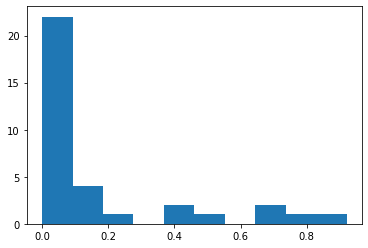

In [125]:
# List the recalls for the other targets and make a histogram
recall_list = []
for i, col in enumerate(Y_test.columns):
    if i == 0:
        # Skip the 'related' target
        continue
    report = classification_report(Y_test[col], Y_pred[:, i], 
                                   zero_division=0, output_dict=True)
    try:
        recall = report['1']['recall']
    except KeyError:
        # In this case there are no instances in Class 1
        recall = 0
    recall_list.append(recall)

plt.hist(recall_list)
plt.show()

For the majority of the 34 other targets, the recall is less than 10%, leaving a lot to be desired.

In [128]:
X_test

21047    A young army doctor running a field clinic set...
12462     The storm is hitting us directly, in a hole I go
25670    In this capacity, Ly covers the entire rural c...
13913    After the cyclone of 18 October and the super ...
14720    The Save and the Buzi rivers are reportedly ri...
                               ...                        
9563        I need some information about the earthquake. 
2894     ALAS WE ARE DYING OF HUNGER AND THIRST. WE ARE...
20602    Key priorities include identifying and verifyi...
26125    Yudhoyone, who swept to power last September o...
13565    This is also the opportunity to develop a bett...
Name: message, Length: 7809, dtype: object

In [130]:
test_pred = cv.best_estimator_.predict_proba(X_test)

In [139]:
Y_test.columns

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'water', 'food', 'shelter', 'clothing', 'money', 'missing_people',
       'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'],
      dtype='object')

I have one more idea for improving predictions using this pipeline: I can look at the precion-recall curves and see if I should change the decision threshold for some of the classifiers to favor higher recall at the cost of some precision.

Unfortunately, I found that this does not work. For example, for the 'request' column, here is a plot of the precision-recall curve:

request: fraction_1 = 0.171


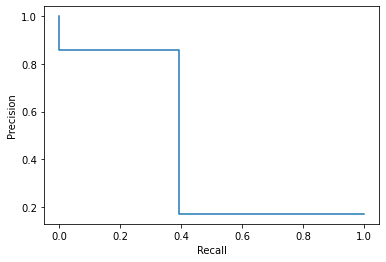

In [192]:
# Plot the precision-recall curve for the 'request' column (column 1)
col = 'request'
num = 1
report = classification_report(Y_test[col], Y_pred[:, num], 
                               zero_division=0, output_dict=True)
frac = report['1']['support']/(report['0']['support'] + report['1']['support'])
print(f'\033[1m{col}:\033[0m fraction_1 = {frac:.3g}')
precision, recall, _ = precision_recall_curve(Y_test[col], Y_pred[:, num])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

Here 'fraction_1' is the fraction of test set instances in class 1. The recall from my predictor above is 0.392; observe that unless I'm willing to use a trivial classifier that marks all instances '1', this recall is the best I can do. In general this is true if there are no more than 3 points on the precision-recall curve. Are there any with more than three points?

In [199]:
# Make a list of lists, where each inner list contains the precisions of one
# of the classifiers
precision_lists = []
# Same as the previous list, but for the recall
recall_lists = []
for num, col in enumerate(Y_test.columns):
    report = classification_report(Y_test[col], Y_pred[:, num], 
                                   zero_division=0, output_dict=True)
    precisions, recalls, _ = precision_recall_curve(Y_test[col], Y_pred[:, num])
    precision_lists.append(precisions)
    recall_lists.append(recalls)

In [200]:
# Check if any of the recall lists have length greater than 3
for num, col in enumerate(Y_test.columns):
    if len(recall_lists[num]) > 3:
        print(col)

Yep, no luck with this approach.

Ideas for further study: 
- Try Word2Vec instead of CountVectorizer for features.
- Could try using XGBoost instead of random forests, though I'm not sure if this will lead to significant improvement.
- Try using keras-tcn (temporal CNN) for modeling intead of a random forest.

## Export the model

It's time to export my model for use in a machine learning pipeline. I'll use Python's `pickle` module. Another popular option is `joblib`.

In [201]:
# Pickle the model and save to 'final_model.pkl'
with open('final_model.pkl', 'wb') as f:
    pickle.dump(cv.best_estimator_, f)

In [202]:
# Make sure reloading the model works
with open('final_model.pkl' , 'rb') as f:
    loaded_model = pickle.load(f)
# Check whether the predictions match
np.where((cv.best_estimator_.predict(X_test) == loaded_model.predict(X_test)) is False)

(array([], dtype=int64),)

Good, the predictions are the same, i.e. the model has been saved and then reloaded correctly.